In [1]:
%load_ext dotenv
%dotenv

import numpy as np
import networkx as nx
from neo4j import GraphDatabase
import os
import matplotlib.pyplot as plt
import dspy
import itertools

/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
db_url = os.getenv("DB_HOST", "neo4j://localhost:7687")
db_user = os.getenv("DB_USER", "neo4j")
db_pass = os.getenv("DB_PASSWORD", "no_password")
db_base = os.getenv("DB_DATABASE", "neo4j")
label_model = os.getenv("LABEL_MODEL", "openai/gpt-4o-mini")

export_temp = "/tmp/communities_neo4j_export.graphml"

if not os.path.isfile(export_temp):
	print("Connecting to db")
	with GraphDatabase.driver(db_url, auth=(db_user, db_pass)) as driver:
		driver.verify_connectivity()

		print("Fetching database as graphml")
		records, _, _ = driver.execute_query("""
			CALL apoc.export.graphml.all(null, {stream:true})
			YIELD file, nodes, relationships, properties, data
			RETURN file, nodes, relationships, properties, data
		""")
		_, n_nodes, n_relationships, _, export_contents = records[0]
		print(f"Downloaded {n_nodes} nodes, {n_relationships} relationships")

		print("Saving as temporary file")
		with open(export_temp, "w") as f:
			f.write(export_contents)

print("Loading databse from file")
graph = nx.read_graphml(export_temp)


Connecting to db
Fetching database as graphml
Downloaded 3996 nodes, 2864 relationships
Saving as temporary file
Loading databse from file


/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/networkx/readwrite/graphml.py:1034: UserWarning: No key type for id id. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/networkx/readwrite/graphml.py:1034: UserWarning: No key type for id labels. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/networkx/readwrite/graphml.py:1034: UserWarning: No key type for id label. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/networkx/readwrite/graphml.py:1034: UserWarning: No key type for id tags. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")


In [3]:
communities = nx.community.louvain_communities(graph)
print(f"Found {len(communities)} communities")

communities.sort(key=lambda v: len(v), reverse=True)

k = 20
print(f"First {k} have populations {[len(c) for c in communities[:k]]}")

Found 1935 communities
First 20 have populations [172, 129, 128, 103, 90, 90, 88, 87, 82, 80, 76, 74, 65, 63, 62, 58, 51, 50, 28, 21]


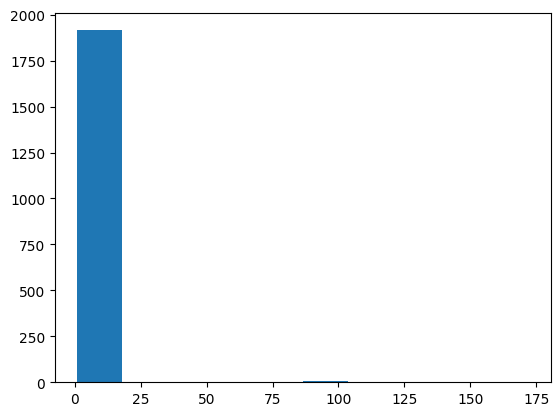

In [4]:
plt.hist([len(c) for c in communities])
plt.show()

# Seems that we get a lot of communities with very few members
# I know that a lot of entities in the data have no endges connecting them
# This is likely why this happens
# TODO: test this after filtering them 

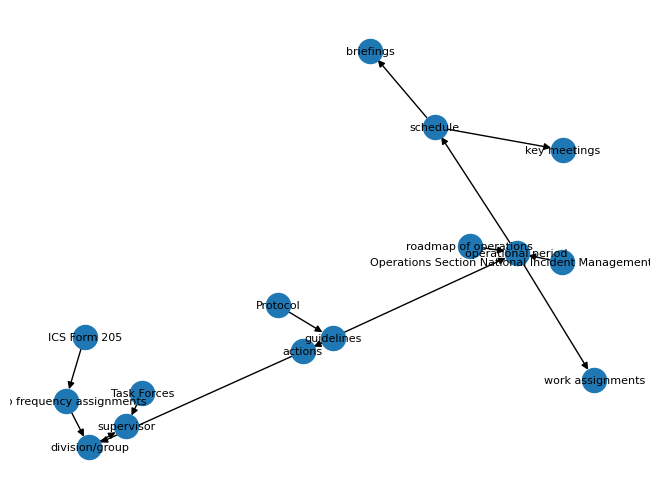

In [5]:
def draw_subgraph(subgraph, **kwargs):
	nx.draw_spring(subgraph, labels=dict(subgraph.nodes(data="id")), font_size=8, **kwargs)

draw_subgraph(graph.subgraph(communities[22]))

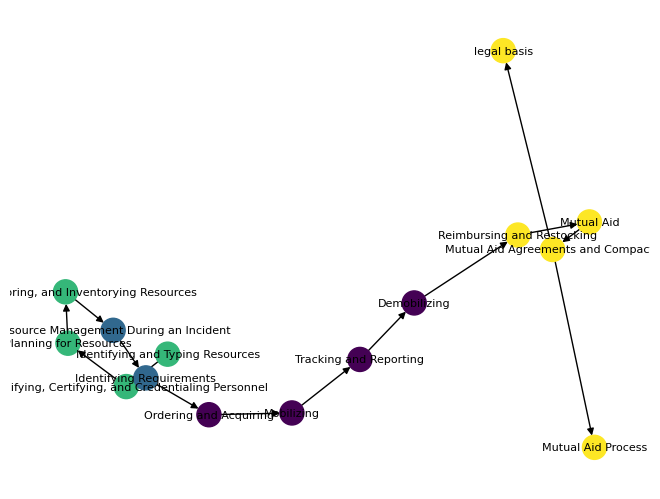

In [6]:
def draw_subgraph_communities(subgraph, communities):
	colours = []
	for node in subgraph:
		i = [i for i, c in enumerate(new_communities) if node in c][0]
		colours.append(i)
	draw_subgraph(subgraph, node_color=colours)

subgraph = graph.subgraph(communities[21])
new_communities = nx.community.louvain_communities(subgraph)

draw_subgraph_communities(subgraph, communities)

In [7]:

lm = dspy.LM(label_model)
dspy.configure(lm=lm)

class CommunityLabelSignature(dspy.Signature):
	"""
	Given a collection of entities, find a few words to label them.
	"""
	entities: list[str] = dspy.InputField()
	# context: str = dspy.InputField() # This bleeds into its answers
	label: str = dspy.OutputField()	

_label_community_p = dspy.Predict(CommunityLabelSignature)

def label_entities(entities):
	return _label_community_p(entities=entities).label

def label_community(graph, community):
	return label_entities([l for n, l in graph.subgraph(community).nodes(data="id")])

def label_community_demo(graph, community):
	entities = [l for n, l in graph.subgraph(community).nodes(data="id")]
	print(f"Graph with contents")
	for e in entities:
		print("\t", e)
	label = label_community(graph, community)
	print(f"is labeled as '{label}'")

label_community_demo(graph, communities[28])

Graph with contents
	 Logistics Section Personnel
	 Supplies
	 Food Services
	 Transportation
	 Incident Traffic Plans
	 Cooking Facilities
	 Vehicle Usage Records
	 Food Security and Safety
	 Facilities
	 Food Service Areas
	 Ground Transportation
	 Food and Water Needs
is labeled as 'Logistics and Food Services Management'


In [8]:
# Recursively splits communities with at least `threshold` members 
# Retuns list of (this) or node id
def recursive_louvain(graph, threshold=10):
	communities = nx.community.louvain_communities(graph)
	result = []
	for community in communities:
		if len(community) >= threshold:
			# Recurse
			subgraph = graph.subgraph(community)
			result.append(recursive_louvain(subgraph, threshold=threshold))
		else:
			# Terminal community
			result.append(community)
	return result

print(recursive_louvain(graph.subgraph(communities[20]), threshold=5))

[{'n165'}, {'n836'}, {'n49'}, {'n2289'}, {'n2186'}, {'n4105'}, {'n3431'}, {'n2536'}, {'n2300'}, {'n2604'}, {'n41'}, {'n1236'}, {'n3410'}, {'n357'}, {'n2662'}]


In [9]:
# turn louvain communities into labels bottom-up
def recursive_labels(graph, communities):
	if isinstance(communities, list):
		inner = [recursive_labels(graph, c) for c in communities]
		labels, _ = zip(*inner)
		# print(f"Make label for {labels}")
		return (label_entities(labels), inner)
	else:
		# Temrinal is a set
		# print(f"Make terminal label for {communities}")
		return (label_community(graph, list(communities)), [])

g = recursive_louvain(graph.subgraph(communities[20]), threshold=5)
print(recursive_labels(graph, g))

('"Operational Insights and Impact"', [('Facility Management', []), ('Communications Status', []), ('"Energy and Environmental Innovations"', []), ('Public Health Impact', []), ('Charitable Contributions', []), ('"Future Events"', []), ('Geophysical Data', []), ('"Geographical Limits"', []), ('Weather Events', []), ('Transportation Status', []), ('Aerial Surveillance Status', []), ('Disaster Management', []), ('Safety Guidelines', []), ('"Access and Boundaries"', []), ('"Impact Analysis"', [])])


In [10]:

def communities_labels_graph_recursive(labels):
	g = nx.Graph()

	def dfs_node_addition(graph, labels, parent):
		root, children = labels
		graph.add_node(root)
		if parent:
			graph.add_edge(parent, root)
			# print(f"{parent} -> {root}")
		
		for label in children:
			dfs_node_addition(graph, label, root)

	dfs_node_addition(
		g,
		labels,
		None,
	)

	return g

def draw_circle_graph_thing(graph):
	pos = nx.nx_agraph.graphviz_layout(graph, prog="twopi", args="")
	plt.figure(figsize=(8, 8))
	nx.draw(graph, pos, node_size=20, alpha=0.75, node_color="blue", with_labels=True, font_size=10)
	plt.axis("equal")
	plt.show()

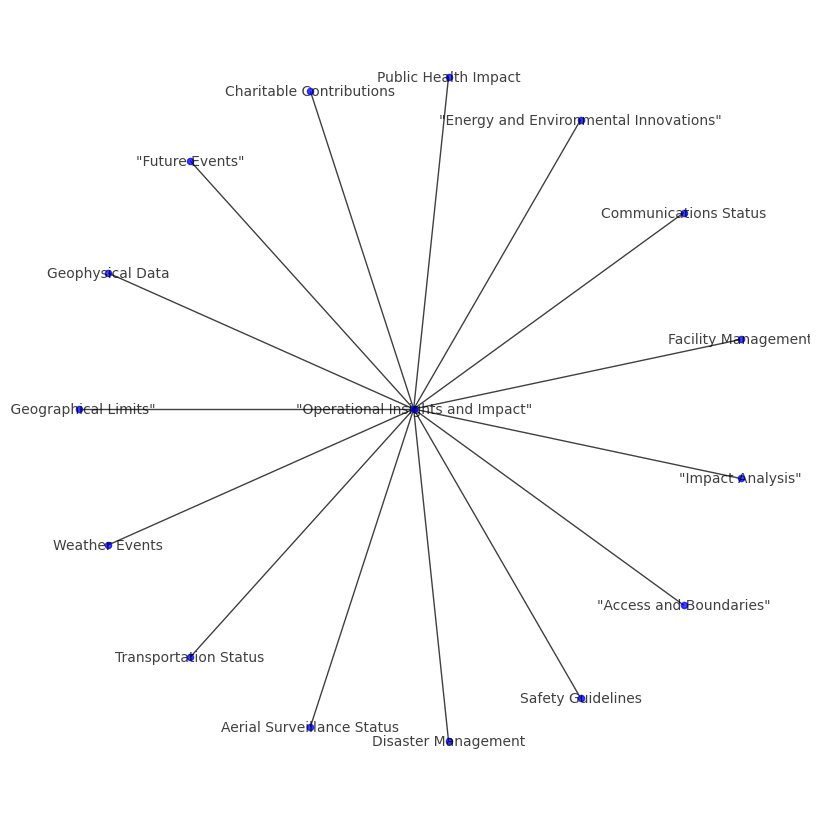

In [11]:
community = recursive_louvain(graph.subgraph(communities[20]), 5)
labels = recursive_labels(graph, community)

g = communities_labels_graph_recursive(labels)
draw_circle_graph_thing(g)

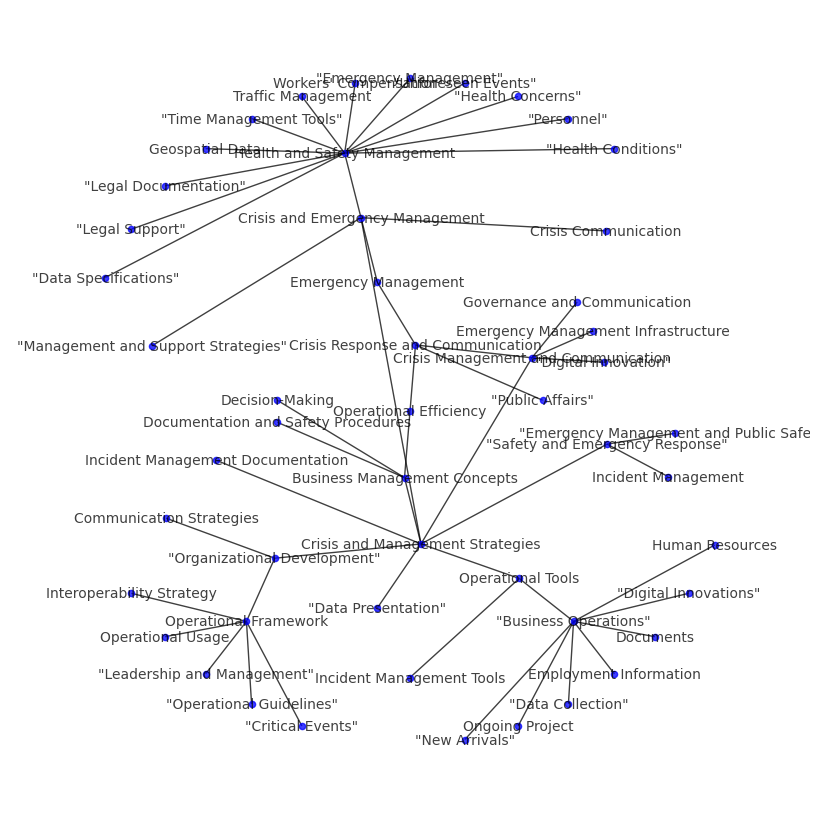

In [12]:
community = recursive_louvain(graph.subgraph(communities[10]), 5)
labels = recursive_labels(graph, community)

g = communities_labels_graph_recursive(labels)
draw_circle_graph_thing(g)

In [13]:
print(f"That has {len(communities[10])} communities (plus their sub-communities)")
print(f"The full graph has {len(communities)} communities (plus their sub-communities!!!)")
print(f"I will not process that unless instructed to do so (expensive?)")

That has 76 communities (plus their sub-communities)
The full graph has 1935 communities (plus their sub-communities!!!)
I will not process that unless instructed to do so (expensive?)


# Girvan-Newman

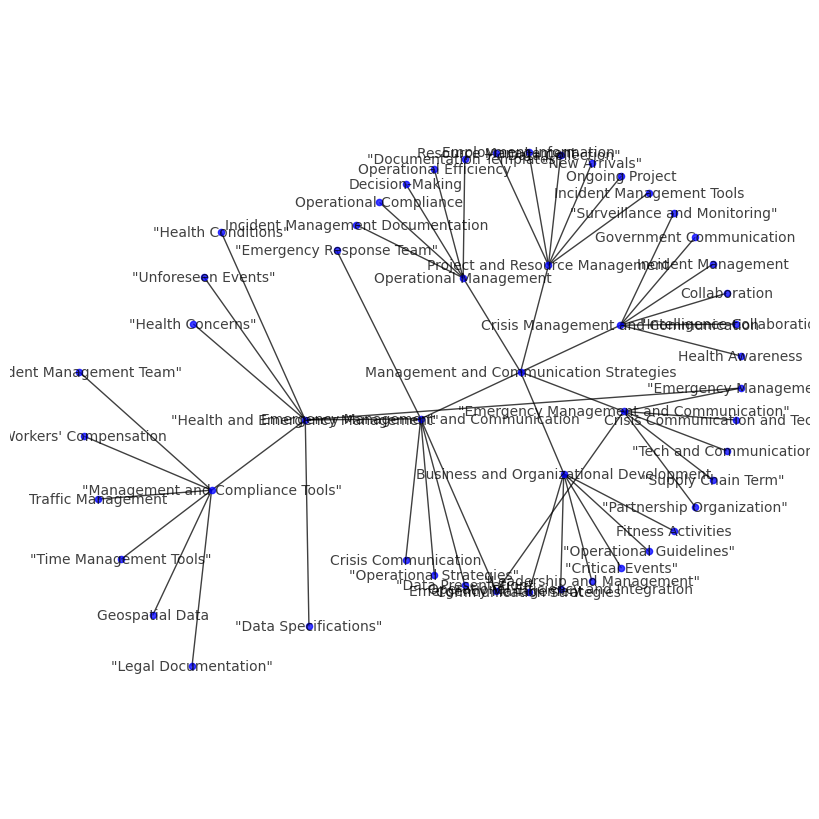

In [14]:
def recursive_gn(graph, threshold=8, target=4):
	comp = nx.community.girvan_newman(graph)
	communities = next(itertools.islice(comp, target, None))
	result = []
	for community in communities:
		if len(community) >= threshold:
			subgraph = graph.subgraph(community)
			result.append(recursive_gn(subgraph, threshold=threshold, target=target))
		else:
			result.append(community)
	return result

community = recursive_gn(graph.subgraph(communities[10]))
labels = recursive_labels(graph, community)

g = communities_labels_graph_recursive(labels)
draw_circle_graph_thing(g)

# Interesting that it now interprets this cluster as being militaristic 

# Filtering Isolates

Found 224 communities
First 20 have populations [174, 150, 105, 95, 81, 81, 80, 79, 79, 79, 69, 69, 66, 64, 64, 59, 56, 55, 46, 36]
Last 20 have populations [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


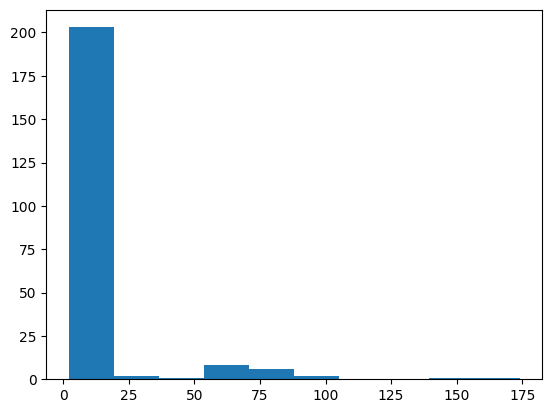

In [15]:
isolates = list(nx.isolates(graph))
connected_graph = graph.copy()
connected_graph.remove_nodes_from(isolates)

communities = nx.community.louvain_communities(connected_graph)
print(f"Found {len(communities)} communities")
communities.sort(key=lambda v: len(v), reverse=True)
k = 20
print(f"First {k} have populations {[len(c) for c in communities[:k]]}")
print(f"Last {k} have populations {[len(c) for c in communities[::-1][:k][::-1]]}")

plt.hist([len(c) for c in communities])
plt.show()

Graph with 62 nodes and 61 edges


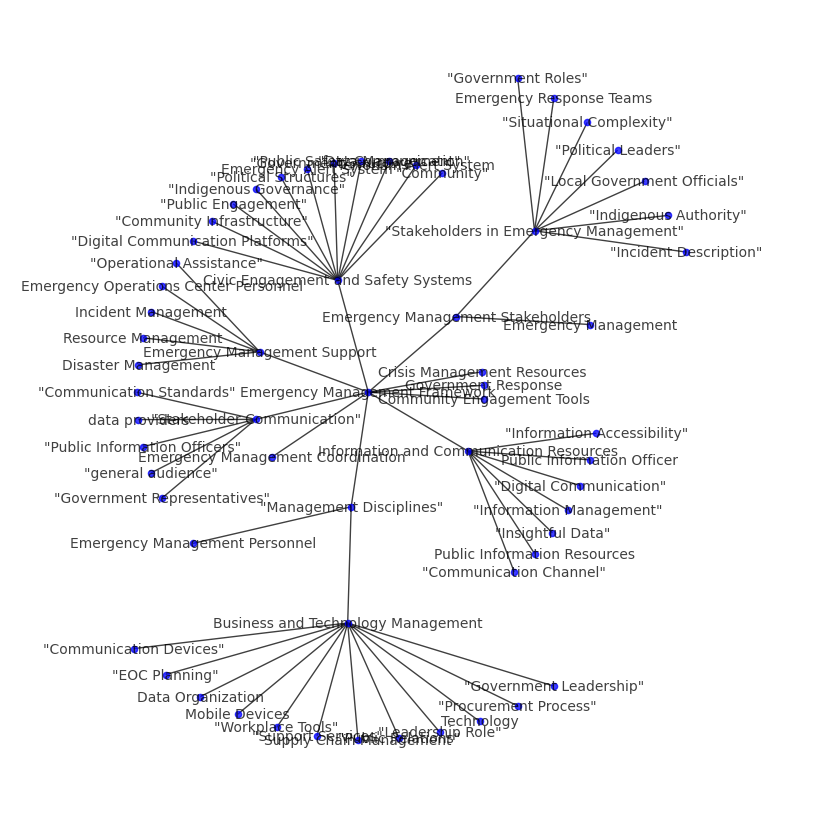

In [18]:
community = recursive_louvain(graph.subgraph(communities[10]), 5)
labels = recursive_labels(graph, community)

g = communities_labels_graph_recursive(labels)
draw_circle_graph_thing(g)

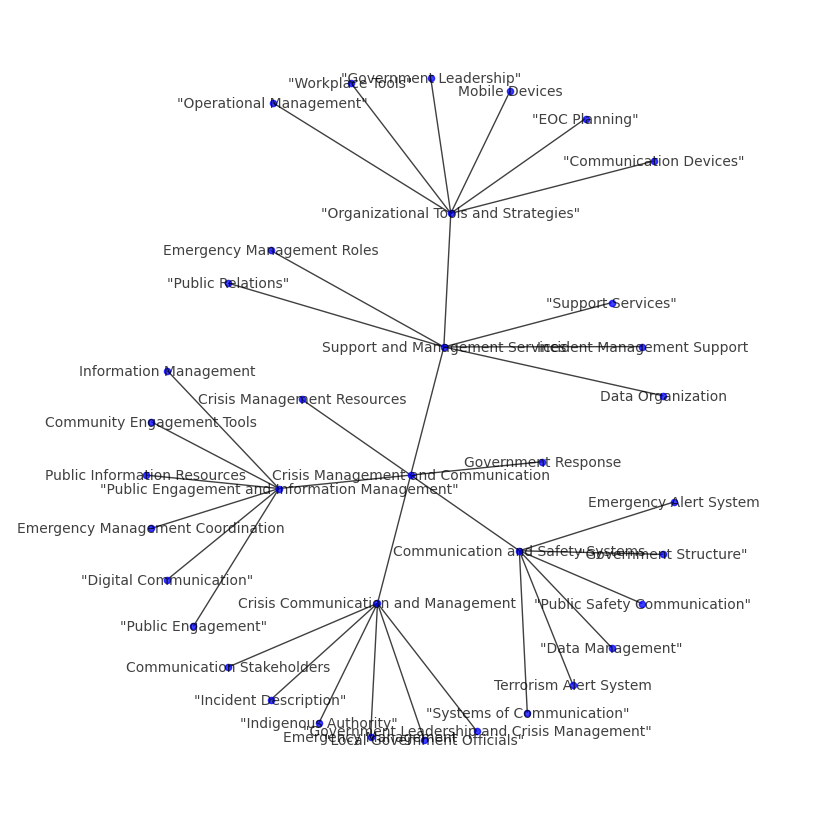

In [17]:
community = recursive_gn(graph.subgraph(communities[10]))
labels = recursive_labels(graph, community)

g = communities_labels_graph_recursive(labels)
draw_circle_graph_thing(g)

In [ ]:
import neo4j
import networkx as nx
import itertools

db_url = os.getenv("DB_HOST", "neo4j://localhost:7687")
db_user = os.getenv("DB_USER", "neo4j")
db_pass = os.getenv("DB_PASSWORD", "no_password")
db_base = os.getenv("DB_DATABASE", "neo4j")
label_model = os.getenv("LABEL_MODEL", "openai/gpt-4o-mini")


# Pulls an entire neo4j database and makes a networkx graph from it
def nx_graph_neo4j(driver):
	export_temp = "/tmp/communities_neo4j_export.graphml"

	if not os.path.isfile(export_temp):
		print("Connecting to db")
		with GraphDatabase.driver(db_url, auth=(db_user, db_pass)) as driver:
			driver.verify_connectivity()

			print("Fetching database as graphml")
			records, _, _ = driver.execute_query("""
				CALL apoc.export.graphml.all(null, {stream:true})
				YIELD file, nodes, relationships, properties, data
				RETURN file, nodes, relationships, properties, data
			""")
			_, n_nodes, n_relationships, _, export_contents = records[0]
			print(f"Downloaded {n_nodes} nodes, {n_relationships} relationships")

			print("Saving as temporary file")
			with open(export_temp, "w") as f:
				f.write(export_contents)
	else:
		print("Loading cached database")
	
	graph = nx.read_graphml(export_temp)
	return graph


# Splits a graph into communities 
def graph_communities(
	graph,
	# Any commmunity with more than this many nodes will be further divided
	subdivision_threshold=8, 
	# Communities (try to) split into at most this many subcommunities 
	branchiness=6,
):
	comp = nx.community.girvan_newman(graph)

	communities = next(comp)
	# print(f"Split into {len(communities)} communities")
	# assert False
	result = []
	for community in communities:
		if len(community) > subdivision_threshold:
			# print("Split interior community")
			subgraph = graph.subgraph(community)
			result.append(graph_communities(subgraph))
		else:
			# print("Reached leaf community")
			result.append(community)
	return result


# Finds how many calls we will make to label a community set
# Returns number of calls, number of tokens in those calls
# Tokens are assumed to be words, punctuation is not counted 
# Also does not account for output token cost
def communities_label_count(communities):
	if isinstance(communities, list) or isinstance(communities, set):
		calls = 0
		tokens = 0
		for community in communities:
			c_calls, c_tokens = communities_label_count(community)
			calls += c_calls
			tokens += c_tokens
		return calls, tokens
	else:
		assert isinstance(communities, str)
		return 1, len(communities.split())


lm = dspy.LM(label_model)
dspy.configure(lm=lm)


class CommunityLabelSignature(dspy.Signature):
	"""
	Given a collection of entities, find a few words to label them.
	"""
	entities: list[str] = dspy.InputField()
	label: str = dspy.OutputField()	


_label_community_p = dspy.Predict(CommunityLabelSignature)


def label_entities(entities):
	return _label_community_p(entities=entities).label


def label_community(graph, community):
	return label_entities([l for n, l in graph.subgraph(community).nodes(data="id")])


# Generates labels for a collection of communities 
# Estimate the cost with communities_label_count
def label_communities(graph, communities):
	if isinstance(communities, list):
		inner = [label_communities(graph, c) for c in communities]
		labels, _ = zip(*inner)
		# print(f"Make label for {labels}")
		return (label_entities(labels), inner)
	else:
		# print(f"Make terminal label for {communities}")
		# Temrinal is a set
		assert isinstance(communities, set)
		return (label_community(graph, list(communities)), [])


In [50]:
community = graph_communities(graph.subgraph(communities[10]))
calls, tokens = communities_label_count(community)
token_cost = 1.100 / 1e6
print(f"Labelling will make {calls} calls with {tokens} input tokens ({tokens*token_cost}$)")

Labelling will make 69 calls with 69 input tokens (7.59e-05$)


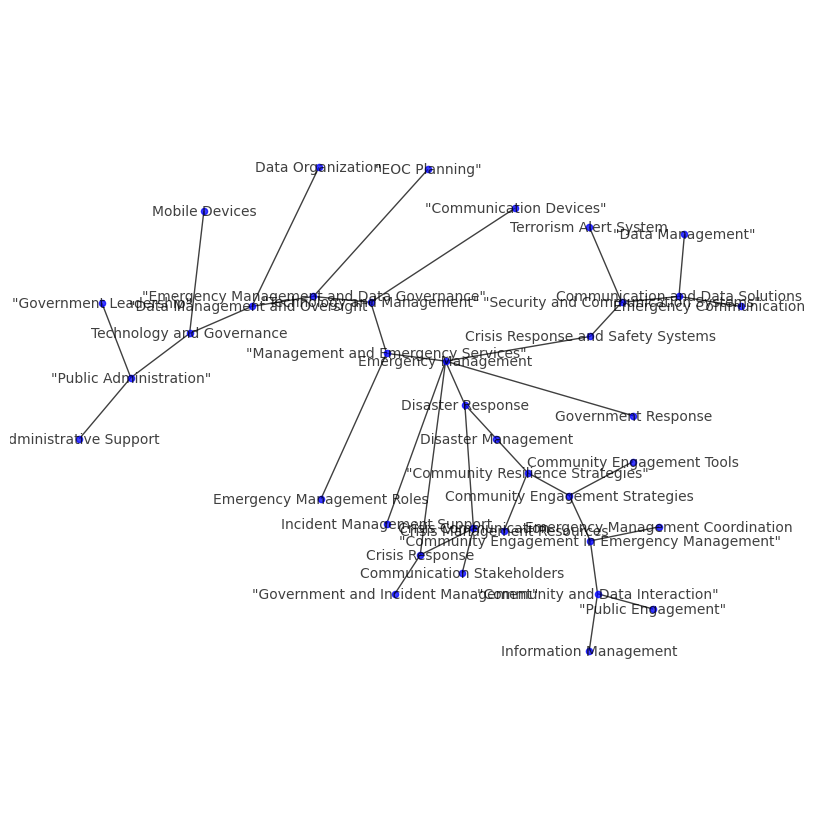

In [61]:
labels = label_communities(graph, community)
g = communities_labels_graph_recursive(labels)
draw_circle_graph_thing(g)

In [ ]:
calls, tokens = communities_label_count(graph_communities(graph))
token_cost = 1.100 / 1e6
print(f"Labelling will make {calls} calls with {tokens} input tokens ({tokens*token_cost}$)")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7e0bf9d0aa50>>
Traceback (most recent call last):
  File "/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
